# Model and data load

In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/pavelpopov/mlp_nn'

In [2]:
from omegaconf import OmegaConf
import torch
import pandas as pd
import seaborn as sns

from copy import deepcopy

from captum.attr import IntegratedGradients, NoiseTunnel, Saliency, visualization as viz
import matplotlib.pyplot as plt
import numpy as np

from src.data import data_factory, data_postfactory
from src.dataloader import dataloader_factory
from src.model import model_config_factory, model_factory

from scipy import stats

/usr/local/anaconda3/envs/mlp_nn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_model_and_data(path):
    cfg = OmegaConf.load(path+'/general_config.yaml')

    df = pd.read_csv(path+'/runs.csv')
    best_idx = df["test_score"].idxmax()
    k = best_idx // cfg.mode.n_trials
    trial = best_idx - cfg.mode.n_trials * k
    print("k ", k)
    print("trial ", trial)

    original_data = data_factory(cfg)
    model_cfg = model_config_factory(cfg, k)
    data = data_postfactory(
            cfg,
            model_cfg,
            original_data,
        )
    dataloaders = dataloader_factory(cfg, data, k=k, trial=trial)

    model = model_factory(cfg, model_cfg)

    model_logpath = path+f"/k_{k:02d}/trial_{trial:04d}/best_model.pt"
    checkpoint = torch.load(
        model_logpath, map_location=lambda storage, loc: storage
    )
    model.load_state_dict(checkpoint)

    return model, dataloaders, checkpoint

In [4]:
neuromark = pd.read_csv("/Users/pavelpopov/mlp_nn/assets/data/neuromark_regions.csv")
neuromark["Index"]=neuromark["Index"]-1
neuromark = {a: (b, c, d, e, f) for a, b, c, d, e, f in zip(neuromark["Index"], neuromark["Name"], neuromark["Network"], neuromark["X"], neuromark["Y"], neuromark["Z"])}

# Introspection

In [7]:
class Introspector:
    """Basic introspector"""

    def __init__(self, model, features, labels, methods, save_path) -> None:
        self.methods = methods
        self.save_path = save_path
        self.model = model

        self.features = features
        self.labels = labels

        # os.makedirs(f"{self.save_path}timeseries", exist_ok=True)
        if "saliency" in self.methods:
            # os.makedirs(f"{self.save_path}saliency/colormap", exist_ok=True)
            # os.makedirs(f"{self.save_path}saliency/barchart", exist_ok=True)
            os.makedirs(f"{self.save_path}saliency", exist_ok=True)
        if "ig" in self.methods:
            # os.makedirs(f"{self.save_path}ig/colormap", exist_ok=True)
            # os.makedirs(f"{self.save_path}ig/barchart", exist_ok=True)
            os.makedirs(f"{self.save_path}ig", exist_ok=True)
        if "ignt" in self.methods:
            # os.makedirs(f"{self.save_path}ignt/colormap", exist_ok=True)
            # os.makedirs(f"{self.save_path}ignt/barchart", exist_ok=True)
            os.makedirs(f"{self.save_path}ignt", exist_ok=True)

    def run(self, cutoff=1, percentile=0.1):
        """Run introspection, save results"""
        targets = torch.unique(self.labels)
        n_classes = targets.shape[0]

        print(f"Getting MLP predictions for {self.save_path}")
        features, timeseries, smooth_timeseries, predictions = (
            [None]*n_classes, 
            [None]*n_classes, 
            [None]*n_classes, 
            [None]*n_classes,
        )

        window_size = 10
        for class_idx in range(n_classes):
            filter_array = self.labels == class_idx
            features[class_idx] = self.features[filter_array]
            features[class_idx].requires_grad = False

            timeseries_raw, predictions[class_idx] = self.model(features[class_idx], introspection=True)
            timeseries_raw = timeseries_raw.cpu().detach().numpy()
            predictions[class_idx] = predictions[class_idx].cpu().detach().numpy()
            
            # timeseries_raw was calculated for the data related to class_idx;
            # yet it has `n_classes` class prediction time series in 3rd dimension
            # so timeseries[class_idx] is a list of length n_classes, each element of which
            # represents the class prediction time series
            timeseries[class_idx] = [timeseries_raw[:, :, j] for j in range(n_classes)]

            smooth_timeseries[class_idx] = deepcopy(timeseries[class_idx])
            for j in range(n_classes):
                for subject in range(smooth_timeseries[class_idx][j].shape[0]):
                    smooth_timeseries[class_idx][j][subject] = np.convolve(smooth_timeseries[class_idx][j][subject], np.ones(window_size)/window_size, mode='same')

        
        grads = {key: None for key in self.methods}
        specific_grads = {key: None for key in self.methods}
        for method in self.methods:
            print(f"Processing {method}")

            sizes = [features[j].shape for j in range(n_classes)]
            # print(features[0].shape)
            # print(features[0].reshape(-1, 1, 53).shape)
            # grads[method] = [self.get_grads(method, features[j].reshape(-1, 1, 53), j).cpu().detach().numpy().reshape(*sizes[j]) for j in range(n_classes)]
            grads[method] = [self.get_grads(method, features[j], j).cpu().detach().numpy() for j in range(n_classes)]
            print(grads[method][0].shape)

            np.save(f"{self.save_path}{method}/grads_0.npy", grads[method][0])
            np.save(f"{self.save_path}{method}/grads_1.npy", grads[method][1])

            specific_grads[method] = []
            for i in range(n_classes):
                if i == 0:
                    filter_array = np.argwhere(timeseries[i][0] > timeseries[i][1])
                else:
                    filter_array = np.argwhere(timeseries[i][0] < timeseries[i][1])
                
                specific_grads[method].append(np.array([grads[method][i][x, y, :] for (x, y) in filter_array]))

            # print(specific_grads[method][0].shape)
            # print(grads[method][0].shape)
            np.save(f"{self.save_path}{method}/filtered_grads_0.npy", specific_grads[method][0])
            np.save(f"{self.save_path}{method}/filtered_grads_1.npy", specific_grads[method][1])

        # plot everything
        for method in self.methods:
            print(f"Plotting {method}")

            for i in range(n_classes):
                print(f"Plotting time series for true target {i}")
                self.plot_timeseries(
                    timeseries=timeseries[i], 
                    smooth_timeseries=smooth_timeseries[i], 
                    grads=grads[method][i],
                    features=features[i],
                    predictions=predictions[i],
                    target=i,
                    cutoff=cutoff, 
                    filepath=f"{self.save_path}{method}/timeseries_target_{i}"
                )

            print(f"Plotting spatial attention")
            self.plot_histograms(
                grads=specific_grads[method],
                # grads=grads[method],
                features=features,
                cutoff=cutoff, 
                filepath=f"{self.save_path}{method}/spatial",
                percentile=percentile
            )



    def plot_timeseries(self, timeseries, smooth_timeseries, grads, features, predictions, target, filepath, cutoff, use_log=False):
        fig, ax = plt.subplots(2, cutoff,figsize=(3*cutoff, 4))

        x = np.arange(timeseries[0].shape[1])
        for i in range(cutoff):
            smooth_line_0 = ax[0][i].plot(x[:140], smooth_timeseries[0][i][:140], label='0', color='blue')
            smooth_line_1 = ax[0][i].plot(x[:140], smooth_timeseries[1][i][:140], label='1', color='red')
            line_0 = ax[0][i].plot(x[:140], timeseries[0][i][:140], '#00009922')
            line_1 = ax[0][i].plot(x[:140], timeseries[1][i][:140], '#99000022')

            # ax[i].set_title(f"True target = {target}, Predicted target = {predictions[i]}")
            ax[0][i].legend(title="Prediction")
            
            ax[0][i].set_xlim(0, 140)
            ax[0][i].set_xticklabels([])
            ax[0][i].set_xticks([])
            ax[0][i].set_yticklabels([])
            ax[0][i].set_yticks([])
            ax[0][i].set_xlabel("Time")
            ax[0][i].set_ylabel("Prediction strength" if i == 0 else "")

            # grad = (grads[i]*smooth_timeseries[target][i][:, np.newaxis])[np.newaxis, :, :]
            grad = (grads[i]*smooth_timeseries[target][i][:, np.newaxis])[np.newaxis, :, :]
            feat = features[i].cpu().detach().numpy()[np.newaxis, :, :]
            _, _ = viz.visualize_image_attr(
                np.transpose(grad, (2, 1, 0))[:,:140, :],
                np.transpose(feat, (2, 1, 0))[:,:140, :],
                method="heat_map",
                cmap="inferno",
                show_colorbar=False,
                plt_fig_axis=(fig, ax[1][i]),
                use_pyplot=False,
            )
            ax[0][i].grid()

        fig.savefig(
            f"{filepath}.png",
            format="png",
            dpi=300,
            bbox_inches="tight",
        )
        fig.savefig(
            f"{filepath}.svg",
            format="svg",
            bbox_inches="tight",
        )

        
    def plot_histograms(self, grads, features, cutoff, filepath, percentile=0.1):
        sns.reset_defaults()
        if len(grads[0].shape) == 3:
            data_0 = grads[0].reshape(-1, grads[0].shape[2])
            data_1 = grads[1].reshape(-1, grads[1].shape[2])
            x = np.arange(grads[0].shape[2])
        else:
            data_0 = grads[0]
            data_1 = grads[1]
            x = np.arange(grads[0].shape[1])
        
        print(data_0.shape)

        # fig, ax = plt.subplots(1, 4, figsize=(cutoff+3, 7))
        fig, ax = plt.subplots(1, 3, figsize=(18, 14))
        # fig, ax = plt.subplots(1, 2, figsize=(12, 14))


        df_0 = pd.DataFrame(data_0, columns=[i for i in range(data_0.shape[1])])
        df_0['Class'] = 0
        df_1 = pd.DataFrame(data_1, columns=[i for i in range(data_1.shape[1])])
        df_1['Class'] = 1
        df = pd.concat([df_0, df_1], ignore_index=True)
        df = pd.melt(df, id_vars=['Class'], var_name='Component', value_name='Data')
        sns.boxplot(df, y="Component", x="Data", hue="Class", ax=ax[0], palette=["blue", "red"], showfliers = False, orient='h', linewidth=0.3)
        ax[0].grid(axis='y', linestyle='--', alpha=0.3, linewidth=0.3)
        ax[0].invert_yaxis()
        ax[0].set_yticks(x, x, fontsize=6)
        ax[0].set_ylim(-3, 55)
        ax[0].set_title("Gradients")

        # test = stats.mannwhitneyu(np.abs(data_0), np.abs(data_1))
        test = stats.mannwhitneyu(data_0, data_1)
        pvals = test.pvalue
        pvals = stats.false_discovery_control(pvals, method='by')
        significant_p_vals = np.argwhere(pvals < 0.05)
        # significant_p_vals = np.argwhere(pvals < 0.05 / pvals.shape[0])
        # pvals = pvals / pvals.shape[0]
        bars = ax[1].barh(
            x,
            pvals,
            align="center",
            color='blue',
        )
        ax[1].set_yticks(x, [neuromark[k][0] if k in significant_p_vals else k for k in x], fontsize=6)
        ax[1].set_xlabel("P-value")
        ax[1].set_xscale("log")
        ax[1].set_title("P-values")

        for i, bar in enumerate(bars):
            if pvals[i] < 0.05:
                bar.set_color('red')
        # bar charts: summarizes gradients at each component

        if len(grads[0].shape) == 3:
            data_0 = np.median(grads[0], axis=(0, 1))
            data_1 = np.median(grads[1], axis=(0, 1))
        else:
            data_0 = np.median(grads[0], axis=0)
            data_1 = np.median(grads[1], axis=0)
        
        min_0, max_0 = np.min(data_0), np.max(data_0)
        min_1, max_1 = np.min(data_1), np.max(data_1)
        min_v, max_v = min(min_0, min_1), max(max_0, max_1)
        if min_v <= 0:
            max_v = max(abs(min_v), abs(max_v))
            min_v = -1.0*max_v
        else:
            min_v = 0
                
        sym_data_0 = np.zeros(x.shape)
        sym_data_1 = np.zeros(x.shape)
        asym_data_0 = np.zeros(x.shape)
        asym_data_1 = np.zeros(x.shape)

        for j in x:
            sym_data_0[j] = np.sign(data_0[j]) * np.min((np.abs(data_0[j]), np.abs(data_1[j])))
            sym_data_1[j] = np.sign(data_1[j]) * np.min((np.abs(data_0[j]), np.abs(data_1[j])))
            asym_data_0[j] = data_0[j] - sym_data_0[j]
            asym_data_1[j] = data_1[j] - sym_data_1[j]

        abs_grad = np.abs(data_0) + np.abs(data_1)
        abs_sym_grad = np.abs(sym_data_0) + np.abs(sym_data_1)
        abs_asym_grad = np.abs(asym_data_0) + np.abs(asym_data_1)
        significant_comp = np.argsort(abs_grad)[-int(percentile*x.shape[0]):]
        significant_sym_comp = np.argsort(abs_sym_grad)[-int(percentile*x.shape[0]):]
        significant_asym_comp = np.argsort(abs_asym_grad)[-int(percentile*x.shape[0]):]

        all_significant = np.intersect1d(significant_comp, np.intersect1d(significant_sym_comp, significant_asym_comp))
        all_significant = {
            "idx": all_significant,
            "name": [neuromark[k][0] for k in all_significant],
            "network": [neuromark[k][1] for k in all_significant],
            "x": [neuromark[k][2] for k in all_significant],
            "y": [neuromark[k][3] for k in all_significant],
            "z": [neuromark[k][4] for k in all_significant],
        }
        pd.DataFrame(all_significant).to_csv(f"{filepath}_significant.csv")


        ax[2].barh(
            x,
            data_0,
            align="center",
            color='blue',
            label='0', 
            alpha=0.7,
        )

        ax[2].barh(
            x,
            data_1,
            align="center",
            color='red',
            label='1', 
            alpha=0.7,
        )
        ax[2].set_xlim(min_v, max_v)
        ax[2].grid(axis='y', linestyle='--', alpha=0.5)
        ax[2].set_yticks(x, [neuromark[k][0] if k in significant_comp else k for k in x], fontsize=6)
        ax[2].set_title("Grad medians")
        # ax[2].set_xticks([], [])
        
        # ax[2].barh(
        #     x,
        #     sym_data_0,
        #     align="center",
        #     color='blue',
        #     label='0', 
        #     alpha=0.7,
        # )
        # ax[2].barh(
        #     x,
        #     sym_data_1,
        #     align="center",
        #     color='red',
        #     label='1', 
        #     alpha=0.7,
        # )
        # ax[2].set_xlim(min_v, max_v)
        # ax[2].grid(axis='y', linestyle='--', alpha=0.5)
        # ax[2].set_yticks(x, [neuromark[k][0] if k in significant_sym_comp else k for k in x], fontsize=6)
        # # ax[2].set_xticks([], [])

        # ax[3].barh(
        #     x,
        #     asym_data_0,
        #     align="center",
        #     color='blue',
        #     label='0', 
        #     alpha=0.7,
        # )
        # ax[3].barh(
        #     x,
        #     asym_data_1,
        #     align="center",
        #     color='red',
        #     label='1', 
        #     alpha=0.7,
        # )
        # ax[3].set_xlim(min_v, max_v)
        # ax[3].grid(axis='y', linestyle='--', alpha=0.5)
        # ax[3].set_yticks(x, [neuromark[k][0] if k in significant_asym_comp else k for k in x], fontsize=6)
        # # ax[3].set_xticks([], [])


        fig.savefig(
            f"{filepath}.png",
            format="png",
            dpi=300,
            bbox_inches="tight",
        )
        fig.savefig(
            f"{filepath}.svg",
            format="svg",
            bbox_inches="tight",
        )
    
    def get_grads(self, method, features, target):
        """Returns gradients according to method"""
        if method == "saliency":
            saliency = Saliency(self.model)
            self.model.zero_grad()
            grads = saliency.attribute(features, target=target)
        elif method == "ig":
            ig = IntegratedGradients(self.model, multiply_by_inputs=False)
            # ig = IntegratedGradients(self.model, multiply_by_inputs=True)
            self.model.zero_grad()
            grads, _ = ig.attribute(
                inputs=features,
                target=target,
                baselines=torch.zeros_like(features),
                return_convergence_delta=True,
            )
        elif method == "ignt":
            ig = IntegratedGradients(self.model, multiply_by_inputs=False)
            nt = NoiseTunnel(ig)
            self.model.zero_grad()
            grads, _ = nt.attribute(
                inputs=features,
                target=target,
                baselines=torch.zeros_like(features),
                return_convergence_delta=True,
                nt_type="smoothgrad_sq",
                nt_samples=5,
                stdevs=0.2,
            )
        else:
            raise ValueError(f"'{method}' methods is not recognized")

        return grads

# paths = [
#     "./assets/logs/rerun_all-exp-mlp_defHP-oasis",
#     "./assets/logs/rerun_all-exp-mlp_defHP-fbirn",
#     "./assets/logs/rerun_all-exp-mlp_defHP-abide_869"
# ]
# methods = ["saliency", "ig", "ignt"]
paths = [
    "./assets/logs/rerun_all-exp-mlp_defHP-fbirn",
]
methods = ["ig"]
# methods = ["ignt"]
# methods = ["saliency"]

for path in paths:
    model, data, _ = load_model_and_data(path)

    dataset = data["test"].dataset
    features = [sample[0] for sample in dataset]
    labels = [sample[1] for sample in dataset]

    load_only_test = True
    if not load_only_test:
        dataset = data["test"].dataset
        for sample in dataset:
            features.append(sample[0])
            labels.append(sample[1])

    features = torch.stack(features)
    labels = torch.stack(labels)

    introspector = Introspector(
        model=model, 
        features=features, 
        labels=labels, 
        methods=methods, 
        save_path=f"{path.replace('/logs/','/introspection/')}/"
    )
    introspector.run(cutoff=10, percentile=0.3)

k  3
trial  7
Loaded model config:
dropout: 0.11
hidden_size: 150
num_layers: 0
lr: 0.00027
input_size: 53
output_size: 2

Getting MLP predictions for ./assets/introspection/rerun_all-exp-mlp_defHP-fbirn/
Processing ig
(30, 140, 53)
Plotting ig
Plotting time series for true target 0
Plotting time series for true target 1
Plotting spatial attention
(2421, 53)


# Do stuff

## Tree

In [7]:
model, data, checkpoint = load_model_and_data("./assets/logs/rerun_all-exp-mlp_defHP-fbirn")

dataset = data["test"].dataset
all_features = [sample[0] for sample in dataset]
all_labels = [sample[1] for sample in dataset]
all_features = torch.stack(all_features)
all_labels = torch.stack(all_labels)

final_weight = checkpoint["fc.4.2.weight"].numpy()
final_bias = checkpoint["fc.4.2.bias"].numpy()
starting_weight = checkpoint["fc.2.weight"].numpy()
starting_bias = checkpoint["fc.2.bias"].numpy()

k  3
trial  7
Loaded model config:
dropout: 0.11
hidden_size: 150
num_layers: 0
lr: 0.00027
input_size: 53
output_size: 2



### grads

In [125]:
filter_array = all_labels == 0
features = all_features[filter_array]
features.requires_grad = False
model.zero_grad()

prediction = model(features[0:1])

In [126]:
loss = prediction[0][0]
loss.backward()

In [127]:
final_grad = model.fc[4][2].weight.grad.numpy()
init_grad = model.fc[2].weight.grad.numpy()

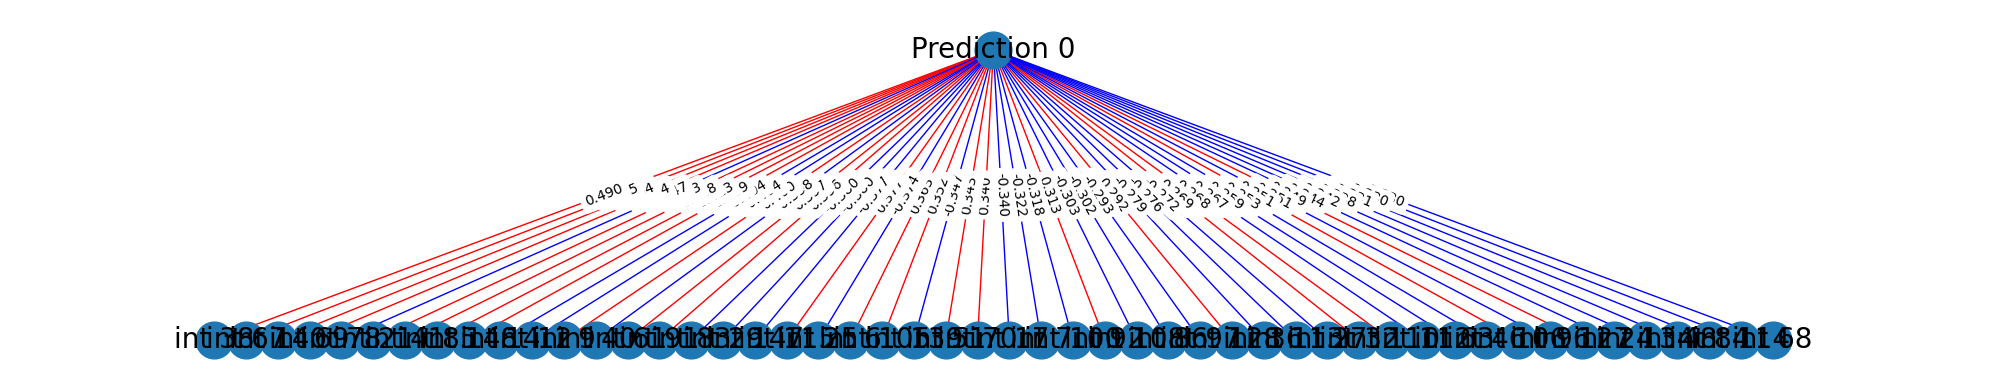

In [129]:
import networkx as nx
import itertools

cutoff = 50

for target in range(2):
    G = nx.Graph()
    plt.figure(figsize=(20,4))
    G.add_node(f"Prediction {target}", name=f"Prediction {target}", layer=2)

    important_final = np.argsort(np.abs(final_grad[target]))[-cutoff:]
    # print(final_weight.shape)
    important_starting = []
    for index in important_final:
        G.add_node(f"int {index}", name=f"int {index}", layer=1)
        G.add_edge(f"Prediction {target}", f"int {index}", weight=final_grad[target, index])

        important_st = np.argsort(np.abs(init_grad[index]))[-cutoff:]
        # for idx in important_st:
        #     G.add_node(f"IC {idx}", name=f"IC {idx}", layer=0)
        #     G.add_edge(f"int {index}", f"IC {idx}", weight=init_grad[index, idx])
            
        important_starting += [important_st]
    
    pos = nx.multipartite_layout(G, subset_key="layer", align='horizontal')
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0]

    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=1, edge_color="r")
    nx.draw_networkx_edges(G, pos, edgelist=esmall, width=1, edge_color="b")
    # node labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    # edge weight labels
    edge_labels = dict([((u,v,), f"{d['weight']:.3f}") for u,v,d in G.edges(data=True)])
    nx.draw_networkx_edge_labels(G, pos, edge_labels)
    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    break

### weights

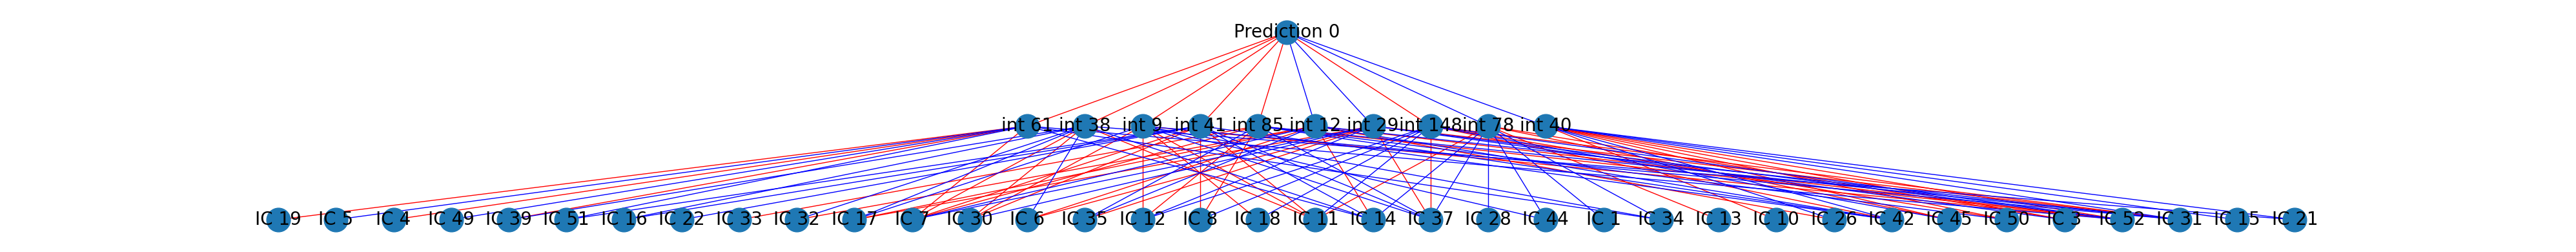

In [73]:
import networkx as nx
import itertools


cutoff = 10

for target in range(2):
    G = nx.Graph()
    plt.figure(figsize=(40,4))
    G.add_node(f"Prediction {target}", name=f"Prediction {target}", layer=2)

    important_final = np.argsort(np.abs(final_weight[target]))[-cutoff:]
    # print(final_weight.shape)
    important_starting = []
    for index in important_final:
        G.add_node(f"int {index}", name=f"int {index}", layer=1)
        G.add_edge(f"Prediction {target}", f"int {index}", weight=final_weight[target, index])

        important_st = np.argsort(np.abs(starting_weight[index]))[-cutoff:]
        for idx in important_st:
            G.add_node(f"IC {idx}", name=f"IC {idx}", layer=0)
            G.add_edge(f"int {index}", f"IC {idx}", weight=starting_weight[index, idx])
            
        important_starting += [important_st]
    
    pos = nx.multipartite_layout(G, subset_key="layer", align='horizontal')
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0]

    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=1, edge_color="r")
    nx.draw_networkx_edges(G, pos, edgelist=esmall, width=1, edge_color="b")
    # node labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    # edge weight labels
    edge_labels = dict([((u,v,), f"{d['weight']:.3f}") for u,v,d in G.edges(data=True)])
    # nx.draw_networkx_edge_labels(G, pos, edge_labels, alpha=0.5)
    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    break

In [66]:
np.sort(np.abs(starting_weight[0, important_starting[0]]))

array([0.00813191, 0.01053225, 0.01407116, 0.01629026, 0.01665042,
       0.01821495, 0.02821172, 0.02992988, 0.03573631, 0.03620625,
       0.03768722, 0.0381178 , 0.03862671, 0.04256342, 0.05173187,
       0.05337241, 0.05899367, 0.06436069, 0.06588411, 0.06815237,
       0.06894355, 0.07566784, 0.07861768, 0.08180807, 0.09077433,
       0.09144645, 0.09283995, 0.10226104, 0.1034072 , 0.10637226,
       0.10872361, 0.11182905, 0.11335222, 0.11944199, 0.12186707,
       0.13136859, 0.13767509, 0.14631115, 0.16513295, 0.20417039],
      dtype=float32)

In [24]:
np.max(np.abs(final_weight))
np.min(np.abs(final_weight))

0.0011126838

## The rest

In [20]:
# paths = [
#     "./assets/logs/rerun_all-exp-mlp_defHP-oasis",
#     "./assets/logs/rerun_all-exp-mlp_defHP-fbirn",
#     "./assets/logs/rerun_all-exp-mlp_defHP-abide_869"
# ]
# methods = ["saliency", "ig", "ignt"]
paths = [
    "./assets/logs/rerun_all-exp-mlp_defHP-fbirn",
]
methods = ["ig"]

for path in paths:
    model, data, _ = load_model_and_data(path)

    dataset = data["test"].dataset
    features = [sample[0] for sample in dataset]
    labels = [sample[1] for sample in dataset]

    load_only_test = True
    if not load_only_test:
        dataset = data["test"].dataset
        for sample in dataset:
            features.append(sample[0])
            labels.append(sample[1])

    features = torch.stack(features)
    labels = torch.stack(labels)

    introspector = Introspector(
        model=model, 
        features=features, 
        labels=labels, 
        methods=methods, 
        save_path=f"{path.replace('/logs/','/introspection/')}/"
    )
    introspector.run(cutoff=10, percentile=0.3)

k  3
trial  7
Loaded model config:
dropout: 0.11
hidden_size: 150
num_layers: 0
lr: 0.00027
input_size: 53
output_size: 2

Getting MLP predictions for ./assets/introspection/rerun_all-exp-mlp_defHP-fbirn/
Processing ig
Plotting ig
Plotting spatial attention


AttributeError: module 'scipy.stats' has no attribute 'false_discovery_control'

In [9]:
from scipy import stats

method = "ig"
grads_0 = np.load(f"./assets/logs/rerun_all-exp-mlp_defHP-fbirn/introspection/grads_target_0_method_{method}.npy")
grads_1 = np.load(f"./assets/logs/rerun_all-exp-mlp_defHP-fbirn/introspection/grads_target_1_method_{method}.npy")
print(grads_0.shape)
print(grads_1.shape)


target_0 = grads_0.reshape(-1, grads_0.shape[2])
target_1 = grads_1.reshape(-1, grads_1.shape[2])

print(target_0.shape)
print(target_1.shape)

test = stats.ttest_ind(target_0, target_1, equal_var=False)
# test = stats.mannwhitneyu(target_0, target_1)

(30, 140, 53)
(32, 140, 53)
(4200, 53)
(4480, 53)


(30, 140, 53)
(32, 140, 53)


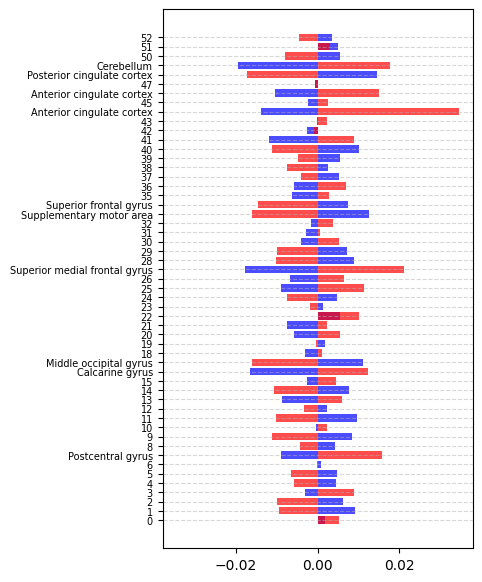

In [36]:
method = "ig"
grads_0 = np.load(f"./assets/logs/rerun_all-exp-mlp_defHP-fbirn/introspection/grads_target_0_method_{method}.npy")
grads_1 = np.load(f"./assets/logs/rerun_all-exp-mlp_defHP-fbirn/introspection/grads_target_1_method_{method}.npy")
print(grads_0.shape)
print(grads_1.shape)

target_0 = grads_0.reshape(-1, grads_0.shape[2])
target_1 = grads_1.reshape(-1, grads_1.shape[2])

mean_A = np.mean(target_0, axis=0)
mean_B = np.mean(target_1, axis=0)

x = np.arange(53)

plt.figure(figsize=(4, 7))
plt.barh(
    x,
    mean_A,
    align="center",
    color='blue',
    label='0', 
    alpha=0.7,
)
plt.barh(
    x,
    mean_B,
    align="center",
    color='red',
    label='1', 
    alpha=0.7,
)
plt.xlim(-0.038, 0.038)
plt.grid(axis='y', linestyle='--', alpha=0.5)

abs_grad = np.abs(mean_A) + np.abs(mean_B)
significatn_components = np.argsort(abs_grad)[-10:]
plt.yticks(x, [neuromark[i][0] if i in significatn_components else i for i in x], fontsize=7) 

plt.savefig(
    "1_all.png",
    format="png",
    dpi=300,
    bbox_inches="tight",
)

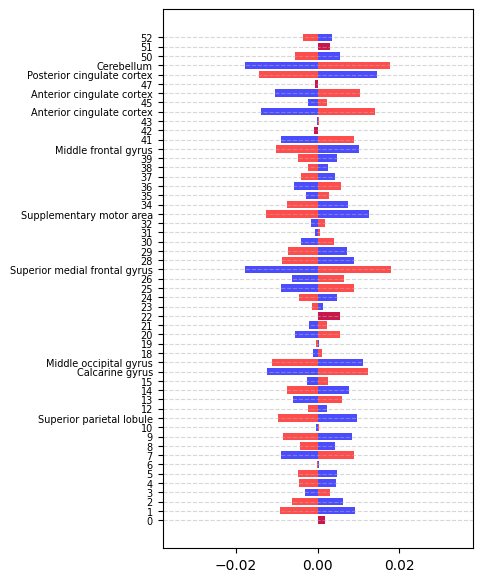

In [60]:
A_1 = np.mean(target_0, axis=0).copy()
B_1 = np.mean(target_1, axis=0).copy()

for i in range(53):
    A_1[i] = np.sign(mean_A[i]) * np.min((np.abs(mean_A[i]), np.abs(mean_B[i])))
    B_1[i] = np.sign(mean_B[i]) * np.min((np.abs(mean_A[i]), np.abs(mean_B[i])))

x = np.arange(53)

plt.figure(figsize=(4, 7))
plt.barh(
    x,
    A_1,
    align="center",
    color='blue',
    label='0', 
    alpha=0.7,
)
plt.barh(
    x,
    B_1,
    align="center",
    color='red',
    label='1', 
    alpha=0.7,
)
plt.xlim(-0.038, 0.038)
plt.grid(axis='y', linestyle='--', alpha=0.5)
abs_grad = np.abs(A_1) + np.abs(B_1)
significatn_components = np.argsort(abs_grad)[-10:]
plt.yticks(x, [neuromark[i][0] if i in significatn_components else i for i in x], fontsize=7) 
plt.savefig(
    "2_sym.png",
    format="png",
    dpi=300,
    bbox_inches="tight",
)

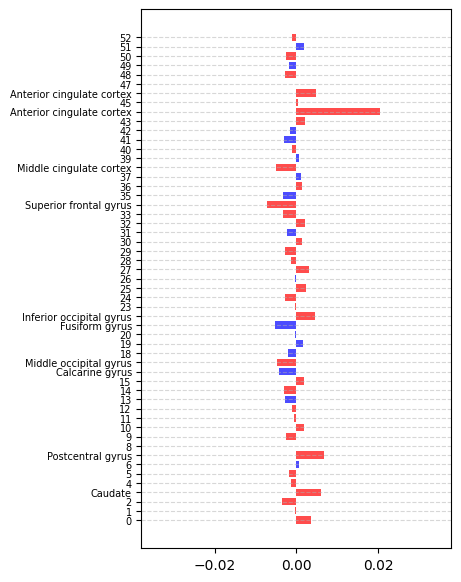

In [61]:
A_2 = np.mean(target_0, axis=0).copy()
B_2 = np.mean(target_1, axis=0).copy()

for i in range(53):
    A_2[i] = mean_A[i] - A_1[i]
    B_2[i] = mean_B[i] - B_1[i]

x = np.arange(53)

plt.figure(figsize=(4, 7))
plt.barh(
    x,
    A_2,
    align="center",
    color='blue',
    label='0', 
    alpha=0.7,
)
plt.barh(
    x,
    B_2,
    align="center",
    color='red',
    label='1', 
    alpha=0.7,
)
plt.xlim(-0.038, 0.038)
plt.grid(axis='y', linestyle='--', alpha=0.5)
abs_grad = np.abs(A_2) + np.abs(B_2)
significatn_components = np.argsort(abs_grad)[-10:]
plt.yticks(x, [neuromark[i][0] if i in significatn_components else i for i in x], fontsize=7) 
plt.savefig(
    "3_asym.png",
    format="png",
    dpi=300,
    bbox_inches="tight",
)

In [31]:
A_0, B = target_0.shape
A_1, B = target_1.shape
# Flatten the arrays to 1D arrays
target_0_flat = target_0.flatten()
target_1_flat = target_1.flatten()
target_flat = np.concatenate([target_0_flat, target_1_flat])

# Create arrays for the indicators
component_array_0 = np.repeat(np.arange(B), A_0)
component_array_1 = np.repeat(np.arange(B), A_1)
component_array = np.concatenate([component_array_0, component_array_1])
target_array_0 = np.array([0]*(A_0*B))
target_array_1 = np.array([1]*(A_1*B))
target_array = np.concatenate([target_array_0, target_array_1])

print(target_flat.shape)
print(component_array.shape)
print(target_array.shape)
# Create the Pandas DataFrame
df = pd.DataFrame({'Data': target_flat,
                   'Component': component_array,
                   'Target': target_array})

(460040,)
(460040,)
(460040,)


In [35]:
import seaborn as sns
from statannot import add_stat_annotation
fig, ax = plt.subplots(1, 1, figsize=(25, 5))

sns.boxplot(df, x="Component", y="Data", hue="Target", showfliers = False, ax=ax)

box_pairs = [((i, 0), (i, 1)) for i in range(53)]
plt.savefig("hi.png")

NameError: name 'df' is not defined

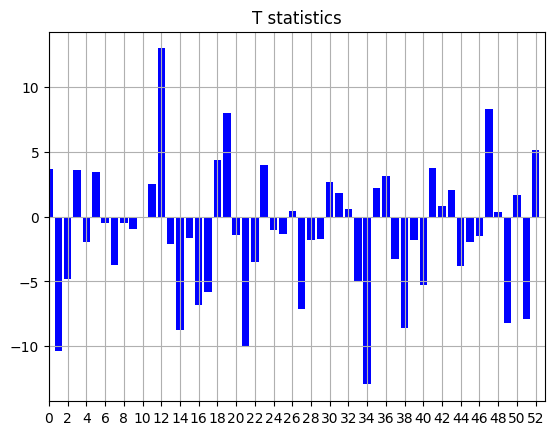

In [33]:
pval = test.statistic
plt.bar(
    range(pval.shape[0]),
    pval,
    align="center",
    color="blue",
)
plt.xticks(list(range(0, pval.shape[0], 2)))
plt.grid()
plt.xlim([0, pval.shape[0]])
plt.title("T statistics")

plt.show()
plt.close()

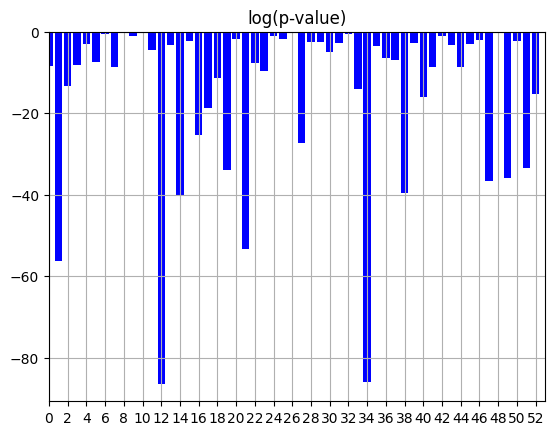

[ 1 12 14 21 34]
Significatn components (log(p_val) < -40)):
Subthalamus/hypothalamus
Paracentral lobule
Superior parietal lobule
Fusiform gyrus
Superior frontal gyrus


In [35]:
pval = test.pvalue
pval = np.log(pval)

fig = plt.figure()
ax = fig.add_subplot(111)
bars = ax.bar(
    range(pval.shape[0]),
    pval,
    align="center",
    color="blue",
)
ax.set_xticks(list(range(0, pval.shape[0], 2)))
ax.grid()
ax.set_xlim([0, pval.shape[0]])
# ax.set_ylim([0, 0.05])
ax.set_title("log(p-value)")

plt.show()
plt.close()

significatn_components = np.where(pval<-40)
print(significatn_components[0])
print("Significatn components (log(p_val) < -40)):")
for i in significatn_components[0]:
    print(neuromark[i][0])

In [ ]:
                    
    # def run(self, cutoff=1, percentile=0.1):
    #     """Run introspection, save results"""
    #     targets = torch.unique(self.labels)
    #     for target in targets:

    #         print(f"Getting MLP predictions for target {target}")  
    #         filter_array = self.labels == target
    #         features = self.features[filter_array]
    #         features.requires_grad = False

    #         timeseries, predictions = self.model(features, introspection=True)
    #         timeseries = timeseries.cpu().detach().numpy()
    #         predictions = predictions.cpu().detach().numpy()

    #         x = np.arange(timeseries.shape[1])
    #         timeseries_0 = timeseries[:, :, 0]
    #         timeseries_1 = timeseries[:, :, 1]

    #         np.save(f"{self.save_path}timeseries_target_{target}.npy", timeseries)
    #         window_size = 10

    #         fig, ax = plt.subplots(1, cutoff,figsize=(3*cutoff, 2))
    #         for i in range(cutoff):
    #             smoothed_data_0 = np.convolve(timeseries_0[i], np.ones(window_size)/window_size, mode='same')
    #             smoothed_data_1 = np.convolve(timeseries_1[i], np.ones(window_size)/window_size, mode='same')
                
    #             smooth_line_0 = ax[i].plot(x, smoothed_data_0, label='0', color='blue')
    #             smooth_line_1 = ax[i].plot(x, smoothed_data_1, label='1', color='red')
    #             line_0 = ax[i].plot(x, timeseries_0[i], '#00009922')
    #             line_1 = ax[i].plot(x, timeseries_1[i], '#99000022')

    #             # ax[i].set_title(f"True target = {target}, Predicted target = {predictions[i]}")
    #             ax[i].legend(title="Prediction")
                
    #             ax[i].set_xticklabels([])
    #             ax[i].set_xticks([])
    #             ax[i].set_yticklabels([])
    #             ax[i].set_yticks([])
    #             ax[i].set_xlabel("Time")
    #             ax[i].set_ylabel("Prediction strength" if i == 0 else "")

    #         fig.savefig(
    #             f"{self.save_path}timeseries/prediction_target_{target}.png",
    #             format="png",
    #             dpi=300,
    #             bbox_inches="tight",
    #         )
    #         fig.savefig(
    #             f"{self.save_path}timeseries/prediction_target_{target}.svg",
    #             format="svg",
    #             bbox_inches="tight",
    #         )

            
    #         for method in self.methods:
    #             filter_array = self.labels == target
    #             features = self.features[filter_array]
    #             features.requires_grad = True

    #             grads = self.get_grads(method, features, target)
    #             grads = grads.cpu().detach().numpy()

    #             np.save(f"{self.save_path}grads_target_{target}_method_{method}.npy", grads)

    #             smoothed_timeseries = np.array([np.convolve(signal[:, target], np.ones(9)/9, mode='same') for signal in timeseries])
    #             smooth_grads = np.log(grads) * smoothed_timeseries[:, :][:, :, np.newaxis]
    #             detached_features = features.cpu().detach().numpy()

    #             # np.save(f"{self.save_path}smooth_grads_target_{target}.npy", grads)
                
    #             print(f"\tPlotting generalized saliency maps using '{method}' with target {target}")
    #             self.plot_colormaps(
    #                 grads,
    #                 detached_features, 
    #                 filepath=f"{self.save_path}{method}/colormap/general_{target}.png",
    #                 color="blue" if target == 0 else "red"
    #             )

    #             self.plot_histograms(
    #                 grads, 
    #                 filepath=f"{self.save_path}{method}/barchart/general_{target}.png",
    #                 percentile=percentile
    #             )

    #             print(f"\tPlotting single sample saliency maps using '{method}' with target {target}")
    #             for i in range(cutoff):
    #                 feature = detached_features[i][np.newaxis, :, :]
    #                 grad = grads[i][np.newaxis, :, :]

    #                 self.plot_colormaps(
    #                     grad,
    #                     feature, 
    #                     filepath=f"{self.save_path}{method}/colormap/target_{target}_idx_{i:04d}.png",
    #                     color="blue" if target == 0 else "red"
    #                 )

    #                 self.plot_histograms(
    #                     grad, 
    #                     filepath=f"{self.save_path}{method}/barchart/target_{target}_idx_{i:04d}.png",
    #                     percentile=percentile
    #                 )